## Dependency specification:

Code to use and update requirement.txt
pip install -r requirements.txt
Update requirements.txt (add xgboost)

### Note: The file contains only In sample evaluation for group 1 of assets.
It saves to outputs_strategy02 : <br>
strategy02_summary - Contains best parameters by quarter and asset. (pd.DataFrame saved as csv and parquet both)<br>
strategy02_perf - Contains evaluation metrics for in-sample period. (pd.DataFrame saved as csv and parquet both) <br>

In [ ]:
# # DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))  # adds project root

## Imports

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Groups of assets

The groups of assets include:

- **Group 1** – two assets (1-minute frequency), **traded during NYSE sessions** on working days between **9:30 and 16:00 CET**:
  - **SP** – futures contract for S&P 500 index (transaction cost = 12$, point value = 50$).
  - **NQ** – futures contract for NASDAQ index (transaction cost = 12$, point value = 20$).


## Functions

In [21]:
# APPLY MASK
def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Creates masks required by the assignment for Group 1:
    - NaN windows for calculations: 9:31-9:40 and 15:51-16:00
    - no trading: 9:31-9:55
    - flat from: 15:40 to end (no overnight)
    """
    t = index.time

    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close

    no_trade = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    flat_from = (t >= pd.to_datetime("15:40").time())

    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": no_trade, "mask_flat_from": flat_from},
        index=index
    )


## Param Tuning on all quarters

### One Place Code Summary
- Cell 1 : i.e The cell below computes a pandas data frame named "summary" which contains all in-sample best parameters (as columns) for all quarters (Group 1 of assets) plus a net pnl column.
- Cell 2 : Saves summary both as a csv and parquet file
- Cell 3 : Creates a pandas dataframe with 7 evaluation metrics (as columns) using pre-defined "summary".

In [41]:
# =========================
# RUN YOUR FINAL TUNING BLOCK ON ALL ../data/*.parquet FOR BOTH SP + NQ + SUMMARY TABLE
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    t = index.time
    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close
    mask_no_trade  = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    mask_flat_from = (t >= pd.to_datetime("15:40").time())
    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": mask_no_trade, "mask_flat_from": mask_flat_from},
        index=index
    )

def tune_one_asset(df: pd.DataFrame, asset: str, point_value: float, tc: float) -> dict:
    # expects df indexed by datetime with df[asset], mask_no_trade, mask_flat_from
    FLIP = False  # kept for parity; unused in tuning

    Px = df[asset].to_numpy()
    n  = len(df)

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    dS = np.diff(Px)

    # ----- your grids (unchanged) -----
    SMA_grid        = [240, 360, 480]
    slow_mult_grid  = [3, 4]
    slope_m_grid    = [5, 10]
    z_entry_grid    = [1.4, 1.6, 1.8, 2.0]
    z_stop_grid     = [3.5, 4.0, 4.5]
    z_sl_grid       = [1.0, 1.5, 2.0]
    z_mom_grid      = [0.05, 0.10, 0.20, 0.30]
    cooldown_grid   = [5, 10]
    # -------------------------------

    best_net_pnl = -np.inf
    best_params  = None
    best_trades  = np.nan

    for SMA_win in SMA_grid:

        SMA = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
        STD = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
        z   = (Px - SMA) / np.where(STD == 0, np.nan, STD)

        for slow_mult in slow_mult_grid:

            SMA_slow_win = int(slow_mult * SMA_win)
            SMA_slow = pd.Series(Px).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

            for slope_m in slope_m_grid:
                for z_entry in z_entry_grid:
                    for z_stop in z_stop_grid:
                        for z_sl in z_sl_grid:
                            for z_mom in z_mom_grid:
                                for cooldown_bars in cooldown_grid:

                                    pos = np.zeros(n, dtype=np.int8)
                                    cooldown = 0

                                    for t in range(1, n):

                                        if MASK_FLAT_FROM[t-1]:
                                            pos[t] = 0
                                            cooldown = 0
                                            continue

                                        if (not np.isfinite(Px[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
                                            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if STD[t-1] <= 0:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if t >= 2 and Px[t-1] == Px[t-2]:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        # ----- Change A: level + slope trend -----
                                        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
                                            slow_up = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
                                            slow_dn = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
                                            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
                                            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
                                        else:
                                            trend_up = False
                                            trend_dn = False
                                        # ----------------------------------------

                                        up_confirm = (t >= 2) and (Px[t-1] > Px[t-2])
                                        dn_confirm = (t >= 2) and (Px[t-1] < Px[t-2])

                                        if t >= 3 and np.isfinite(z[t-2]):
                                            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
                                            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
                                        else:
                                            z_up_mom = False
                                            z_dn_mom = False

                                        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if pos[t-1] == 0:

                                            if cooldown > 0:
                                                pos[t] = 0
                                            else:
                                                if (trend_up and up_confirm and z_up_mom and
                                                    (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                                                    pos[t] = 1
                                                elif (trend_dn and dn_confirm and z_dn_mom and
                                                      (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                                                    pos[t] = -1
                                                else:
                                                    pos[t] = 0

                                        elif pos[t-1] == 1:
                                            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = 1

                                        else:  # pos[t-1] == -1
                                            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = -1

                                        cooldown = cooldown - 1 if cooldown > 0 else 0

                                    trades  = np.abs(np.diff(pos))
                                    r_net   = point_value * (pos[:-1] * dS) - tc * trades
                                    net_pnl = np.nansum(r_net)

                                    if net_pnl > best_net_pnl:
                                        best_net_pnl = net_pnl
                                        best_params  = (SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown_bars)
                                        best_trades  = int(np.nansum(trades))

    return {
        "net_pnl": float(best_net_pnl),
        "trades": best_trades,
        "SMA_win": best_params[0],
        "slow_mult": best_params[1],
        "slope_m": best_params[2],
        "z_entry": best_params[3],
        "z_stop": best_params[4],
        "z_sl": best_params[5],
        "z_mom": best_params[6],
        "cooldown": best_params[7],
    }

DATA_DIR = Path("../data")
rows = []

TX_COST = {"SP": 12.0, "NQ": 12.0}
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}

for fp in sorted(DATA_DIR.glob("*.parquet")):
    dfq = pd.read_parquet(fp)

    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)

    dfq = dfq.sort_index()
    quarter = fp.stem

    masks = add_group1_masks(dfq.index)
    dfq["mask_no_trade"]  = masks["mask_no_trade"].to_numpy(dtype=bool)
    dfq["mask_flat_from"] = masks["mask_flat_from"].to_numpy(dtype=bool)

    for asset in ["SP", "NQ"]:
        out = tune_one_asset(dfq, asset, point_value=POINT_VALUE[asset], tc=TX_COST[asset])
        rows.append({"quarter": quarter, "asset": asset, **out})

summary = pd.DataFrame(rows).sort_values(["quarter", "asset"]).reset_index(drop=True)
summary


,quarter,asset,net_pnl,trades,SMA_win,slow_mult,slope_m,z_entry,z_stop,z_sl,z_mom,cooldown
0,data1_2023_Q1,NQ,18383.12,80,480,4,10,1.4,4.5,2.0,0.05,5
1,data1_2023_Q1,SP,1181.75,100,240,3,5,1.4,4.0,1.0,0.10,5
2,data1_2023_Q3,NQ,10071.20,34,480,3,5,1.8,4.5,1.0,0.30,5
3,data1_2023_Q3,SP,5146.35,50,480,4,5,1.4,4.0,2.0,0.30,5
4,data1_2023_Q4,NQ,28336.64,80,360,3,10,1.6,3.5,2.0,0.10,5
5,data1_2023_Q4,SP,13969.40,92,360,3,5,1.4,3.5,2.0,0.05,5
6,data1_2024_Q2,NQ,33557.52,88,240,4,5,1.8,4.0,1.5,0.10,5
7,data1_2024_Q2,SP,4788.50,60,480,3,5,1.6,3.5,1.0,0.20,5
8,data1_2024_Q4,NQ,17438.26,112,240,3,10,1.4,3.5,1.0,0.05,5
9,data1_2024_Q4,SP,15212.95,80,360,4,5,1.6,3.5,1.0,0.05,5


In [42]:
from pathlib import Path

OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

# save the already-computed summary exactly as it is
summary.to_csv(OUTPUT_DIR / "strategy02_summary.csv", index=False)
summary.to_parquet(OUTPUT_DIR / "strategy02_summary.parquet", index=False)

print("Saved:", OUTPUT_DIR / "strategy02_summary.csv")


Saved: outputs_strategy02/strategy02_summary.csv


In [43]:
# =========================
# FAST PERF BUILD: NO TUNING. RE-RUN ONCE USING SAVED best params IN `summary`.
# Produces: outputs_strategy02/strategy02_perf.csv + per-quarter daily CSVs
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR   = Path("../data")
OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

TX_COST     = {"SP": 12.0, "NQ": 12.0}
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}

def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    t = index.time
    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close
    mask_no_trade  = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    mask_flat_from = (t >= pd.to_datetime("15:40").time())
    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": mask_no_trade, "mask_flat_from": mask_flat_from},
        index=index
    )

def _sharpe_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    sd = x.std(ddof=1)
    if sd == 0 or not np.isfinite(sd): return np.nan
    return float(x.mean() / sd * np.sqrt(252))

def _calmar_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    cum = x.cumsum()
    dd  = (cum - cum.cummax()).min()
    if not np.isfinite(dd) or dd == 0: return np.nan
    ann = x.mean() * 252
    return float(ann / abs(dd))

def summarize_daily(daily: pd.DataFrame) -> dict:
    return {
        "grossSR": _sharpe_annual(daily["gross_pnl"]),
        "netSR":   _sharpe_annual(daily["net_pnl"]),
        "grossCR": _calmar_annual(daily["gross_pnl"]),
        "netCR":   _calmar_annual(daily["net_pnl"]),
        "gross_cumPnL": float(daily["gross_pnl"].sum()),
        "net_cumPnL":   float(daily["net_pnl"].sum()),
        "av.ntrades":   float(daily["trades"].mean()) if len(daily) else np.nan,
    }

def run_params_pos(df: pd.DataFrame, asset: str, params: dict) -> np.ndarray:
    Px = df[asset].to_numpy()
    n  = len(df)

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    SMA_win       = int(params["SMA_win"])
    slow_mult     = int(params["slow_mult"])
    slope_m       = int(params["slope_m"])
    z_entry       = float(params["z_entry"])
    z_stop        = float(params["z_stop"])
    z_sl          = float(params["z_sl"])
    z_mom         = float(params["z_mom"])
    cooldown_bars = int(params["cooldown"])

    SMA = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
    z   = (Px - SMA) / np.where(STD == 0, np.nan, STD)

    SMA_slow_win = int(slow_mult * SMA_win)
    SMA_slow = pd.Series(Px).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

    pos = np.zeros(n, dtype=np.int8)
    cooldown = 0

    for t in range(1, n):

        if MASK_FLAT_FROM[t-1]:
            pos[t] = 0
            cooldown = 0
            continue

        if (not np.isfinite(Px[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if STD[t-1] <= 0:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t >= 2 and Px[t-1] == Px[t-2]:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        # trend: level + slope
        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
            slow_up = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
            slow_dn = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
        else:
            trend_up = False
            trend_dn = False

        up_confirm = (t >= 2) and (Px[t-1] > Px[t-2])
        dn_confirm = (t >= 2) and (Px[t-1] < Px[t-2])

        if t >= 3 and np.isfinite(z[t-2]):
            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
        else:
            z_up_mom = False
            z_dn_mom = False

        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if pos[t-1] == 0:
            if cooldown > 0:
                pos[t] = 0
            else:
                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                    pos[t] = 1
                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                    pos[t] = -1
                else:
                    pos[t] = 0

        elif pos[t-1] == 1:
            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = 1

        else:  # -1
            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = -1

        cooldown = cooldown - 1 if cooldown > 0 else 0

    return pos

def daily_from_intraday(index: pd.DatetimeIndex, gross_intr: np.ndarray, net_intr: np.ndarray, trades_intr: np.ndarray) -> pd.DataFrame:
    dates = pd.to_datetime(index[1:]).normalize()
    daily = pd.DataFrame({"date": dates, "gross_pnl": gross_intr, "net_pnl": net_intr, "trades": trades_intr})
    daily = daily.groupby("date", as_index=False).sum()
    daily["date"] = pd.to_datetime(daily["date"])
    return daily.set_index("date").sort_index()

# ---- REQUIREMENT INPUT: `summary` must already exist (computed earlier) ----
# It must have: quarter, asset, SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown
need_cols = {"quarter","asset","SMA_win","slow_mult","slope_m","z_entry","z_stop","z_sl","z_mom","cooldown"}
missing = need_cols - set(summary.columns)
if missing:
    raise ValueError(f"`summary` is missing columns: {sorted(missing)}")

perf_rows = []

for fp in sorted(DATA_DIR.glob("*.parquet")):
    quarter = fp.stem
    dfq = pd.read_parquet(fp)

    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)

    dfq = dfq.sort_index()
    masks = add_group1_masks(dfq.index)
    dfq["mask_no_trade"]  = masks["mask_no_trade"].to_numpy(dtype=bool)
    dfq["mask_flat_from"] = masks["mask_flat_from"].to_numpy(dtype=bool)

    daily_by_asset = {}

    for asset in ["SP","NQ"]:
        p = summary[(summary["quarter"]==quarter) & (summary["asset"]==asset)].iloc[0].to_dict()

        pos = run_params_pos(dfq, asset, p)
        Px  = dfq[asset].to_numpy()
        dS  = np.diff(Px)
        trades_intr = np.abs(np.diff(pos)).astype(float)

        gross_intr = POINT_VALUE[asset] * (pos[:-1] * dS)
        net_intr   = gross_intr - TX_COST[asset] * trades_intr

        daily = daily_from_intraday(dfq.index, gross_intr, net_intr, trades_intr)
        daily_by_asset[asset] = daily

        daily.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_{asset}_daily.csv", index=False)

        met = summarize_daily(daily)
        perf_rows.append({"quarter": quarter, "asset": asset, **met})

    # portfolio
    d_sp = daily_by_asset["SP"]
    d_nq = daily_by_asset["NQ"]
    idx  = d_sp.index.union(d_nq.index)
    port = pd.DataFrame(index=idx).fillna(0.0)
    port["gross_pnl"] = d_sp["gross_pnl"].reindex(idx, fill_value=0.0) + d_nq["gross_pnl"].reindex(idx, fill_value=0.0)
    port["net_pnl"]   = d_sp["net_pnl"].reindex(idx, fill_value=0.0)   + d_nq["net_pnl"].reindex(idx, fill_value=0.0)
    port["trades"]    = d_sp["trades"].reindex(idx, fill_value=0.0)    + d_nq["trades"].reindex(idx, fill_value=0.0)

    port.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_PORTFOLIO_daily.csv", index=False)

    metp = summarize_daily(port)
    perf_rows.append({"quarter": quarter, "asset": "PORTFOLIO", **metp})

perf_table = pd.DataFrame(perf_rows).sort_values(["quarter","asset"]).reset_index(drop=True)
perf_table.to_csv(OUTPUT_DIR / "strategy02_perf.csv", index=False)
perf_table


,quarter,asset,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades
0,data1_2023_Q1,NQ,2.686558,2.555474,9.070388,8.424582,19343.12,18383.12,1.230769
1,data1_2023_Q1,PORTFOLIO,2.485800,2.240686,7.175615,6.307418,21724.87,19564.87,2.769231
2,data1_2023_Q1,SP,0.606230,0.299976,1.131809,0.533328,2381.75,1181.75,1.538462
3,data1_2023_Q3,NQ,2.708714,2.611590,15.236668,14.258424,10479.20,10071.20,0.523077
4,data1_2023_Q3,PORTFOLIO,2.905158,2.733451,15.429856,13.666741,16225.55,15217.55,1.292308
5,data1_2023_Q3,SP,2.546347,2.289967,9.755504,8.469850,5746.35,5146.35,0.769231
6,data1_2023_Q4,NQ,5.598015,5.427855,31.607716,29.598769,29296.64,28336.64,1.250000
7,data1_2023_Q4,PORTFOLIO,5.446326,5.206257,37.368490,31.867623,44370.04,42306.04,2.687500
8,data1_2023_Q4,SP,4.508426,4.184419,25.820722,22.742294,15073.40,13969.40,1.437500
9,data1_2024_Q2,NQ,4.577226,4.442719,37.152052,35.314663,34613.52,33557.52,1.353846


In [44]:
from pathlib import Path

OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

# save the already-computed perf_table exactly as it is
perf_table.to_csv(OUTPUT_DIR / "strategy02_perf.csv", index=False)
perf_table.to_parquet(OUTPUT_DIR / "strategy02_perf.parquet", index=False)

print("Saved:", OUTPUT_DIR / "strategy02_perf.csv")


Saved: outputs_strategy02/strategy02_perf.csv


## Train / Validation / Test Performance Analysis

In [18]:
# Load the performance table generated earlier
perf_table = pd.read_csv("outputs_strategy02/strategy02_perf.csv")

# Filter for PORTFOLIO results only
portfolio_results = perf_table[perf_table["asset"] == "PORTFOLIO"].copy()

# Define train/validation/test splits according to friend's methodology
train_quarters_list = ["data1_2023_Q1", "data1_2023_Q3", "data1_2023_Q4", 
                       "data1_2024_Q4", "data1_2025_Q1"]  # 5 quarters
validation_quarters_list = ["data1_2024_Q2"]  # 1 quarter
test_quarters_list = ["data1_2025_Q2"]  # 1 quarter (true OOS)

train_res = portfolio_results[portfolio_results["quarter"].isin(train_quarters_list)]
val_res = portfolio_results[portfolio_results["quarter"].isin(validation_quarters_list)]
test_res = portfolio_results[portfolio_results["quarter"].isin(test_quarters_list)]

# Calculate metrics for each set
train_metrics = {
    "Net PnL": train_res["net_cumPnL"].sum(),
    "Avg Sharpe": train_res["netSR"].mean(),
    "Avg Calmar": train_res["netCR"].mean(),
    "STAT Score": sum([(sr - 0.5) * np.log(abs(pnl/1000)) if pnl != 0 and np.isfinite(sr) else 0 
                       for sr, pnl in zip(train_res["netSR"], train_res["net_cumPnL"])]),
    "Quarters": len(train_res)
}

val_metrics = {
    "Net PnL": val_res["net_cumPnL"].sum(),
    "Avg Sharpe": val_res["netSR"].mean(),
    "Avg Calmar": val_res["netCR"].mean(),
    "STAT Score": sum([(sr - 0.5) * np.log(abs(pnl/1000)) if pnl != 0 and np.isfinite(sr) else 0 
                       for sr, pnl in zip(val_res["netSR"], val_res["net_cumPnL"])]),
    "Quarters": len(val_res)
}

test_metrics = {
    "Net PnL": test_res["net_cumPnL"].sum(),
    "Avg Sharpe": test_res["netSR"].mean(),
    "Avg Calmar": test_res["netCR"].mean(),
    "STAT Score": sum([(sr - 0.5) * np.log(abs(pnl/1000)) if pnl != 0 and np.isfinite(sr) else 0 
                       for sr, pnl in zip(test_res["netSR"], test_res["net_cumPnL"])]),
    "Quarters": len(test_res)
}

# Print header
print("\n" + "="*80)
print("TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON")
print("="*80)
print("Training: 2023_Q1, Q3, Q4, 2024_Q4, 2025_Q1 (5 quarters)")
print("Validation: 2024_Q2 (1 quarter - parameter selection)")
print("Test/OOS: 2025_Q2 (1 quarter - completely unseen)")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "Training": train_metrics,
    "Validation": val_metrics,
    "Test (OOS)": test_metrics
})

print(comparison_df.to_string())
print("="*80)


TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON
Training: 2023_Q1, Q3, Q4, 2024_Q4, 2025_Q1 (5 quarters)
Validation: 2024_Q2 (1 quarter - parameter selection)
Test/OOS: 2025_Q2 (1 quarter - completely unseen)
                 Training    Validation    Test (OOS)
Net PnL     113308.100000  38346.020000  41802.030000
Avg Sharpe       2.563838      3.986351      3.021973
Avg Calmar      12.499001     20.562124      8.036357
STAT Score      34.720121     12.713506      9.414385
Quarters         5.000000      1.000000      1.000000


In [19]:
# Overall performance across all quarters
overall_netpnl = portfolio_results["net_cumPnL"].sum()
overall_avg_sharpe = portfolio_results["netSR"].mean()
overall_avg_calmar = portfolio_results["netCR"].mean()

print(f"\n{'='*80}")
print(f"Overall Net PnL (All Quarters): ${overall_netpnl:,.2f}")
print(f"Overall Avg Sharpe Ratio: {overall_avg_sharpe:.4f}")
print(f"Overall Avg Calmar Ratio: {overall_avg_calmar:.4f}")
print(f"{'='*80}")


Overall Net PnL (All Quarters): $193,456.15
Overall Avg Sharpe Ratio: 2.8325
Overall Avg Calmar Ratio: 13.0134


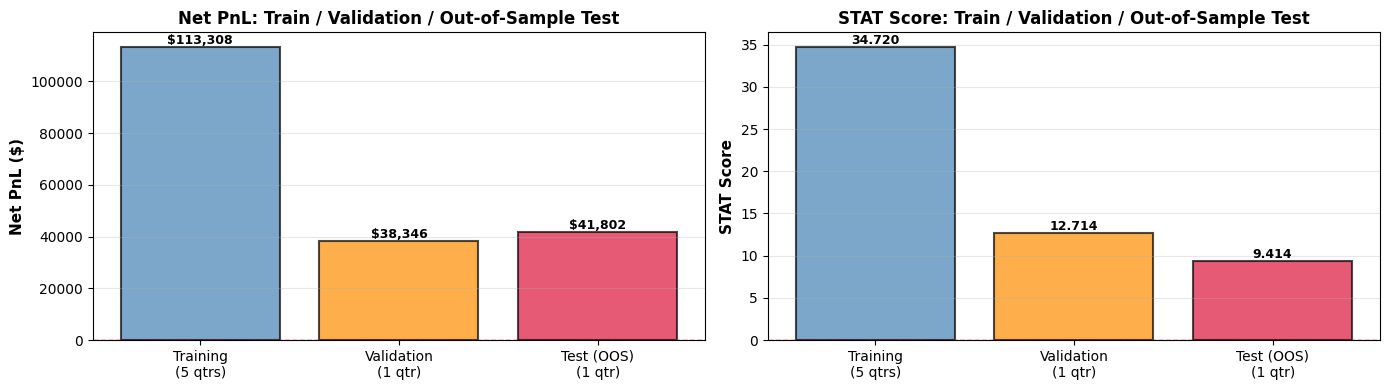


Visualization saved to: outputs_strategy02/train_val_test.png


In [20]:
# Visualize train / validation / test performance
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Panel 1: Net PnL comparison
ax1 = axes[0]
sets = ['Training\n(5 qtrs)', 'Validation\n(1 qtr)', 'Test (OOS)\n(1 qtr)']
pnls = [train_metrics["Net PnL"], val_metrics["Net PnL"], test_metrics["Net PnL"]]
colors = ['steelblue', 'darkorange', 'crimson']
bars = ax1.bar(sets, pnls, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_ylabel('Net PnL ($)', fontsize=11, fontweight='bold')
ax1.set_title('Net PnL: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, pnl in zip(bars, pnls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

# Panel 2: STAT Score comparison  
ax2 = axes[1]
stats = [train_metrics["STAT Score"], val_metrics["STAT Score"], test_metrics["STAT Score"]]
bars = ax2.bar(sets, stats, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_ylabel('STAT Score', fontsize=11, fontweight='bold')
ax2.set_title('STAT Score: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars, stats):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig("outputs_strategy02/train_val_test.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: outputs_strategy02/train_val_test.png")

## Portfolio Performance Visualization

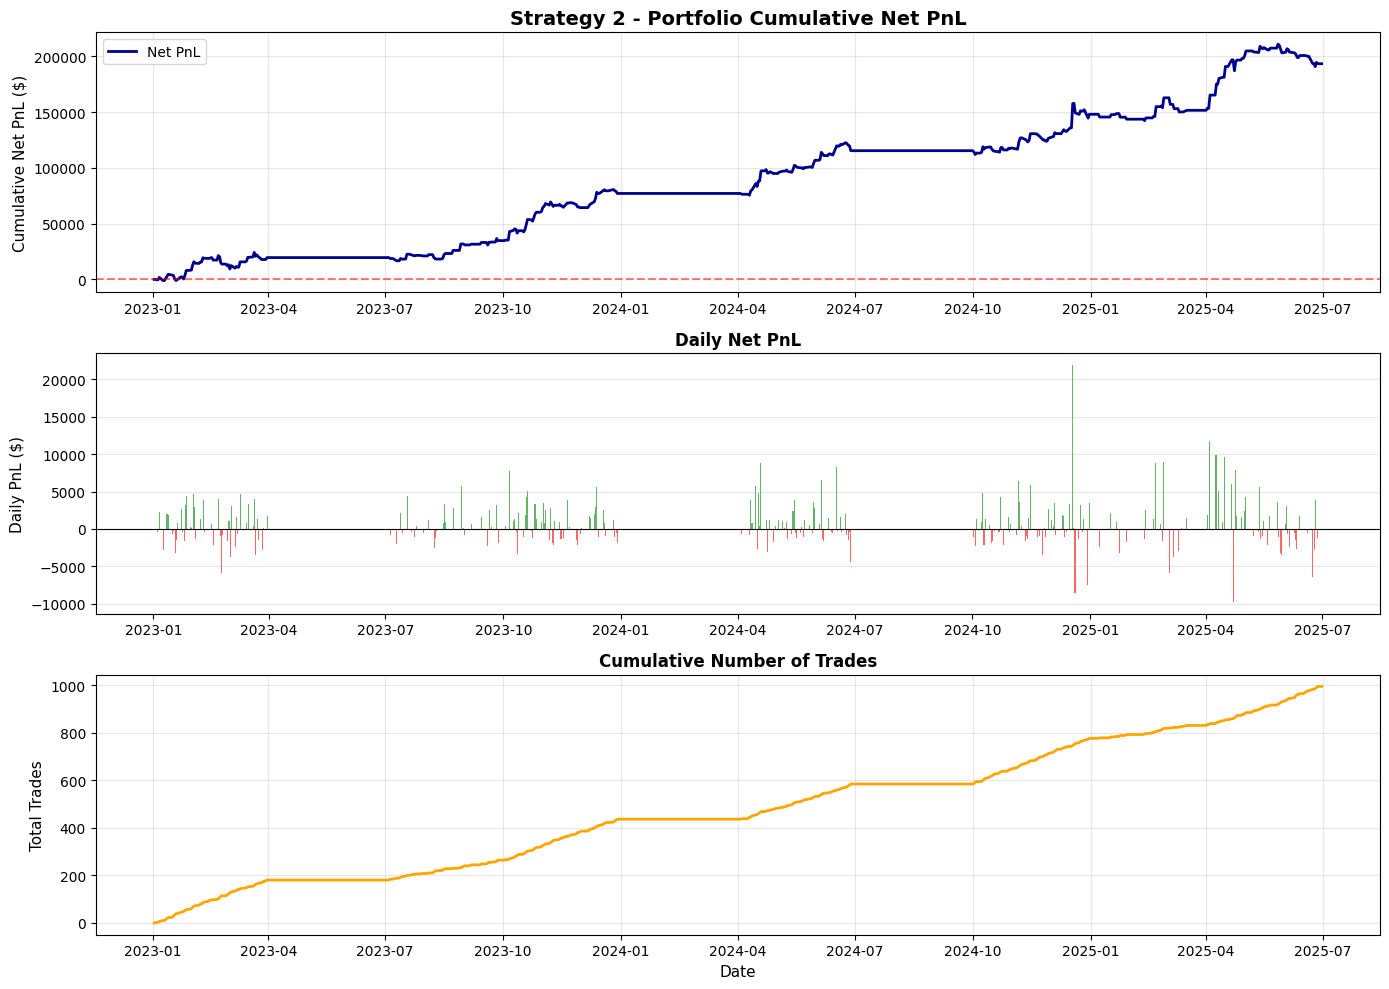


Plot saved to: outputs_strategy02/portfolio_performance.png


In [21]:
# Combine all daily portfolio CSVs for time series analysis
import matplotlib.dates as mdates
from pathlib import Path

all_daily = []
for fp in sorted(Path("outputs_strategy02").glob("*_PORTFOLIO_daily.csv")):
    daily = pd.read_csv(fp)
    daily["date"] = pd.to_datetime(daily["date"])
    daily["quarter"] = fp.stem.replace("_PORTFOLIO_daily", "")
    all_daily.append(daily)

portfolio_full = pd.concat(all_daily, ignore_index=True).sort_values("date")
portfolio_full["cum_net_pnl"] = portfolio_full["net_pnl"].cumsum()
portfolio_full["cum_gross_pnl"] = portfolio_full["gross_pnl"].cumsum()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Cumulative Net PnL
ax1 = axes[0]
ax1.plot(portfolio_full["date"], portfolio_full["cum_net_pnl"], linewidth=2, color='darkblue', label='Net PnL')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_title("Strategy 2 - Portfolio Cumulative Net PnL", fontsize=14, fontweight='bold')
ax1.set_ylabel("Cumulative Net PnL ($)", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 2. Daily Net PnL
ax2 = axes[1]
colors = ['green' if x >= 0 else 'red' for x in portfolio_full["net_pnl"]]
ax2.bar(portfolio_full["date"], portfolio_full["net_pnl"], color=colors, alpha=0.6, width=0.8)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title("Daily Net PnL", fontsize=12, fontweight='bold')
ax2.set_ylabel("Daily PnL ($)", fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 3. Cumulative Trades
ax3 = axes[2]
portfolio_full["cum_trades"] = portfolio_full["trades"].cumsum()
ax3.plot(portfolio_full["date"], portfolio_full["cum_trades"], linewidth=2, color='orange')
ax3.set_title("Cumulative Number of Trades", fontsize=12, fontweight='bold')
ax3.set_xlabel("Date", fontsize=11)
ax3.set_ylabel("Total Trades", fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.savefig("outputs_strategy02/portfolio_performance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: outputs_strategy02/portfolio_performance.png")

## Performance Metrics Summary Table

In [22]:
# Helper functions for metrics
def ann_sharpe(daily_pnl):
    """Annualized Sharpe ratio"""
    if len(daily_pnl) < 2:
        return np.nan
    std = daily_pnl.std()
    if std == 0 or not np.isfinite(std):
        return np.nan
    return daily_pnl.mean() / std * np.sqrt(252)

def ann_calmar(daily_pnl):
    """Annualized Calmar ratio"""
    if len(daily_pnl) < 2:
        return np.nan
    cum = daily_pnl.cumsum()
    dd = (cum - cum.cummax()).min()
    if not np.isfinite(dd) or dd == 0:
        return np.nan
    ann = daily_pnl.mean() * 252
    return ann / abs(dd)

def max_drawdown(cum_pnl):
    """Maximum drawdown"""
    return (cum_pnl - cum_pnl.cummax()).min()

# Performance Metrics Summary
total_days = len(portfolio_full)
total_net_pnl = portfolio_full["net_pnl"].sum()
total_gross_pnl = portfolio_full["gross_pnl"].sum()
total_costs = total_gross_pnl - total_net_pnl
total_trades = portfolio_full["trades"].sum()

# Calculating overall Sharpe and Calmar
overall_sharpe = ann_sharpe(portfolio_full["net_pnl"])
overall_calmar = ann_calmar(portfolio_full["net_pnl"])

# Drawdown
cum_pnl = portfolio_full["cum_net_pnl"]
max_dd = max_drawdown(cum_pnl)

metrics_summary = pd.DataFrame({
    "Metric": [
        "Total Net PnL",
        "Total Gross PnL", 
        "Total Costs",
        "Total Trades",
        "Trading Days",
        "Avg Daily PnL",
        "Win Rate (%)",
        "Annualized Sharpe Ratio",
        "Annualized Calmar Ratio",
        "Maximum Drawdown",
        "Final Cumulative PnL"
    ],
    "Value": [
        f"${total_net_pnl:,.2f}",
        f"${total_gross_pnl:,.2f}",
        f"${total_costs:,.2f}",
        f"{int(total_trades)}",
        f"{total_days}",
        f"${portfolio_full['net_pnl'].mean():,.2f}",
        f"{(portfolio_full['net_pnl'] > 0).sum() / len(portfolio_full) * 100:.1f}%",
        f"{overall_sharpe:.3f}",
        f"{overall_calmar:.3f}",
        f"${max_dd:,.2f}",
        f"${cum_pnl.iloc[-1]:,.2f}"
    ]
})

print("\n" + "="*60)
print("STRATEGY 2 - PORTFOLIO PERFORMANCE SUMMARY")
print("="*60)
print(metrics_summary.to_string(index=False))


STRATEGY 2 - PORTFOLIO PERFORMANCE SUMMARY
                 Metric       Value
          Total Net PnL $193,456.15
        Total Gross PnL $205,384.15
            Total Costs  $11,928.00
           Total Trades         994
           Trading Days         452
          Avg Daily PnL     $428.00
           Win Rate (%)       34.7%
Annualized Sharpe Ratio       2.694
Annualized Calmar Ratio       5.348
       Maximum Drawdown $-20,166.26
   Final Cumulative PnL $193,456.15


## Quarterly Performance Breakdown Visualization

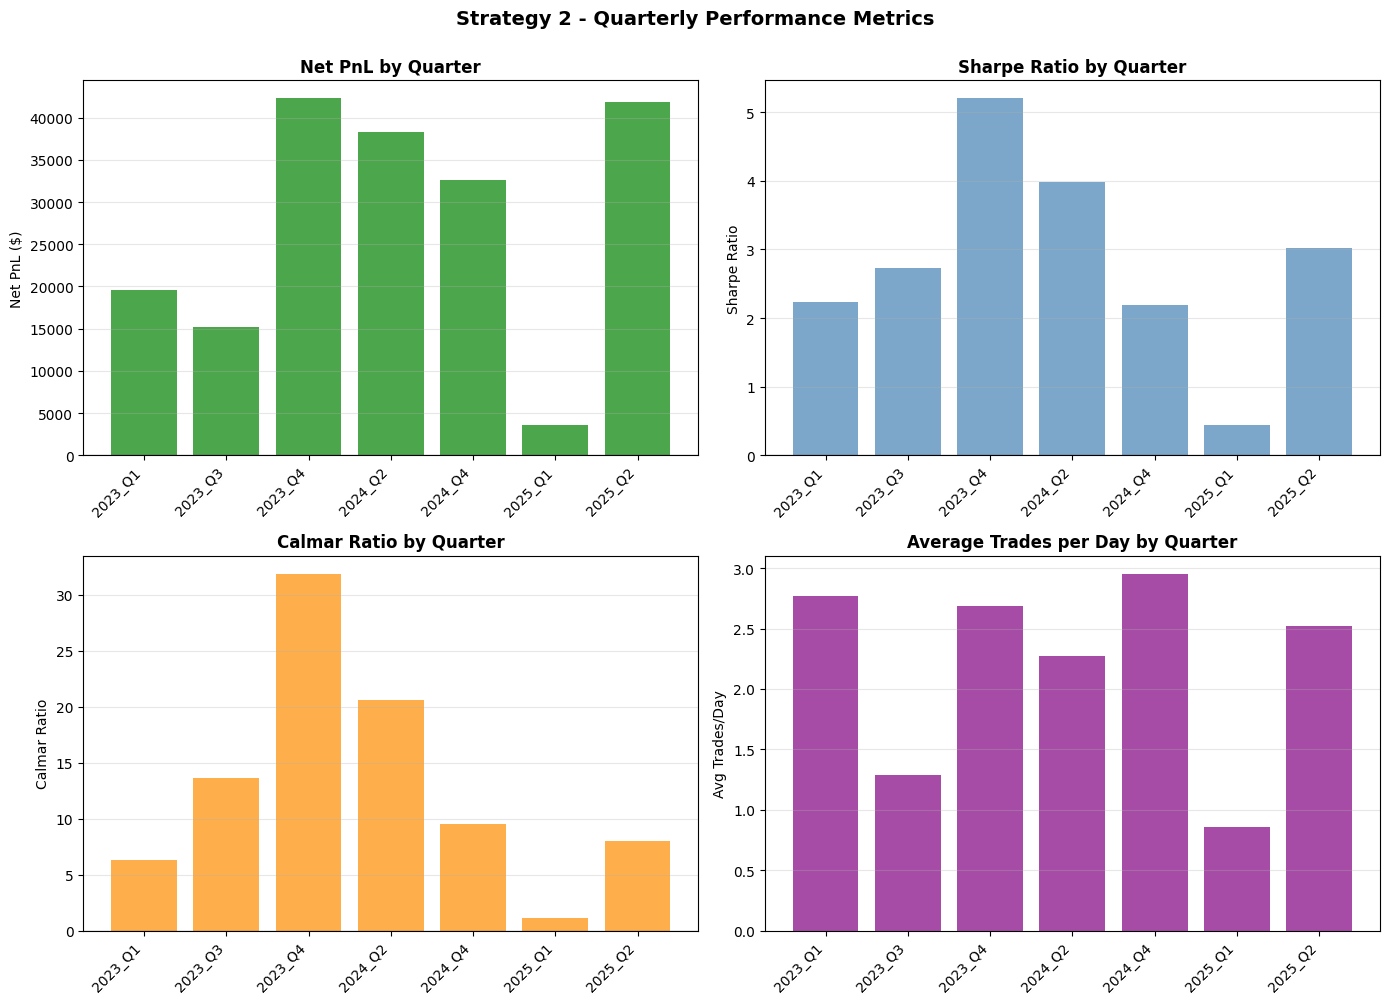


Plot saved to: outputs_strategy02/quarterly_metrics.png


In [23]:
# Quarterly Performance Comparison
portfolio_metrics = portfolio_results.copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Net PnL by Quarter
ax1 = axes[0, 0]
quarters = portfolio_metrics["quarter"].tolist()
net_pnls = portfolio_metrics["net_cumPnL"].tolist()
colors_bars = ['green' if x >= 0 else 'red' for x in net_pnls]
ax1.bar(range(len(quarters)), net_pnls, color=colors_bars, alpha=0.7)
ax1.set_xticks(range(len(quarters)))
ax1.set_xticklabels([q.replace("data1_", "") for q in quarters], rotation=45, ha='right')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title("Net PnL by Quarter", fontsize=12, fontweight='bold')
ax1.set_ylabel("Net PnL ($)", fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Sharpe Ratio by Quarter
ax2 = axes[0, 1]
sharpes = portfolio_metrics["netSR"].tolist()
ax2.bar(range(len(quarters)), sharpes, color='steelblue', alpha=0.7)
ax2.set_xticks(range(len(quarters)))
ax2.set_xticklabels([q.replace("data1_", "") for q in quarters], rotation=45, ha='right')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title("Sharpe Ratio by Quarter", fontsize=12, fontweight='bold')
ax2.set_ylabel("Sharpe Ratio", fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Calmar Ratio by Quarter  
ax3 = axes[1, 0]
calmars = portfolio_metrics["netCR"].tolist()
ax3.bar(range(len(quarters)), calmars, color='darkorange', alpha=0.7)
ax3.set_xticks(range(len(quarters)))
ax3.set_xticklabels([q.replace("data1_", "") for q in quarters], rotation=45, ha='right')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title("Calmar Ratio by Quarter", fontsize=12, fontweight='bold')
ax3.set_ylabel("Calmar Ratio", fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Average Trades per Day by Quarter
ax4 = axes[1, 1]
avg_trades = portfolio_metrics["av.ntrades"].tolist()
ax4.bar(range(len(quarters)), avg_trades, color='purple', alpha=0.7)
ax4.set_xticks(range(len(quarters)))
ax4.set_xticklabels([q.replace("data1_", "") for q in quarters], rotation=45, ha='right')
ax4.set_title("Average Trades per Day by Quarter", fontsize=12, fontweight='bold')
ax4.set_ylabel("Avg Trades/Day", fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle("Strategy 2 - Quarterly Performance Metrics", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("outputs_strategy02/quarterly_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: outputs_strategy02/quarterly_metrics.png")